# 可解释公平指标

## 实验基本环境设置

In [97]:
# 导入依赖
import numpy as np
import pandas as pd
from rich import print
import matplotlib.pyplot as plt
import os
np.random.seed(41)

In [98]:
# 字体设置
from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["Microsoft YaHei"]

## 自定义函数

In [99]:
# 导入自定义函数
%load_ext autoreload
%autoreload 2
from utils.helper import fairness_metrics, test_model  # 测试各种指标并输出图像
from utils.shap_helper import get_ext_train_comp_by_k
from model.models import train_model_and_test
from mydata.adult_0518 import (
    X_train,
    y_train,
    X_test,
    y_test,
    sex,
    feature_index,
    idxs_loc_male,
    idxs_loc_female,
    X_train_male,
    y_train_male,
    X_train_female,
    y_train_female
)  # 获得 数据集 测试集 和 测试集上的敏感属性

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import xgboost

xgboost_origin, res_origin = train_model_and_test(
    X_train,
    y_train,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="原始组",
)
print(res_origin)

{
    '准确率[1.]': 0.8611935715016891,
    '精确率[1.]': 0.7599792638672888,
    '召回率[1.]': 0.6214497668503604,
    'FPR[0.]': 0.06248313090418354,
    'FNR[0.]': 0.3785502331496397,
    'F1 Score[1.]': 0.683768656716418,
    '人口平等 差异[0.]': 0.17209323821642664,
    '人口平等 比率[1.]': 0.3261847832976166,
    '机会均等 差异[0.]': 0.08431715857928956,
    '机会均等 比率[1.]': 0.3004403086659909
}

## 计算得到 Shapley Value

In [101]:
# 计算得到 shapley values
import shap

def get_shapley_value(model, X_train):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_train)
    return shap_values

shap_values = get_shapley_value(xgboost_origin, X_train)

[23:56:24] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [102]:
# 获得 shapley values
shapley_values = shap_values.values
shapley_values.shape

(22792, 14)

## 将 X_train 拆分为 male 和 female

In [103]:
# 在 X_train 训练集上，已知 loc 获得 iloc
idxs_iloc_in_X_train_male = X_train.index.get_indexer(idxs_loc_male)
idxs_iloc_in_X_train_female = X_train.index.get_indexer(idxs_loc_female)

## 计算 Shapley Distance

In [104]:
# 导入新指标，定义敏感属性
from utils.new_index_0518 import (
    shapley_distance_between_individual_and_individual as sdii,
)
from utils.new_index_0518 import shapley_distance_between_individual_and_group as sdig
from utils.new_index_0518 import shapley_distance_between_group_and_group as sdgg

# 因为 X_train 和 shapley values 是一一对应的，所以可以找到对应的 shapley value
shapley_values_male = shapley_values[idxs_iloc_in_X_train_male]
shapley_values_female = shapley_values[idxs_iloc_in_X_train_female]
A = np.array([feature_index])

In [105]:
# 如果有缓存则载入
# 没有就运行函数
def load_or_run_svgg_and_save(
    X,
    A,
    date,
    title,
    dir="np-cache",
):
    filename = f"{date}-{title}"
    filepath = f"{dir}/{filename}.npy"
    print("文件名为: ", filename)
    print("文件路径为: ", filepath)

    if os.path.exists(filepath):
        print("发现缓存数据，直接载入")
        return np.load(filepath)
    print("未发现相关缓存")
    res = sdgg(X, A)
    np.save(filepath, res)
    print("缓存成功")
    return res

## 获得 男性的 Shapley Distance 向量

In [106]:
shap_distance_male = load_or_run_svgg_and_save(shapley_values_male, A, date="2024-05-21", title="50min-可解释指标-sv-male")

文件名为:  2024-05-21-50min-可解释指标-sv-male

文件路径为:  np-cache/2024-05-21-50min-可解释指标-sv-male.npy

发现缓存数据，直接载入

## 获得女性的 Shapley Distance 向量

In [107]:
shap_distance_female = load_or_run_svgg_and_save(shapley_values_female, A, date="2024-05-21", title="11min-可解释指标-sv-female")
shap_distance_female_19 = load_or_run_svgg_and_save(shapley_values_female, A, date="2024-05-19", title="11min-可解释指标-sv-female")

文件名为:  2024-05-21-11min-可解释指标-sv-female

文件路径为:  np-cache/2024-05-21-11min-可解释指标-sv-female.npy

发现缓存数据，直接载入

文件名为:  2024-05-19-11min-可解释指标-sv-female

文件路径为:  np-cache/2024-05-19-11min-可解释指标-sv-female.npy

发现缓存数据，直接载入

## 找到最不公平的 idx

在 shap_distance_male 上和 shap_distance_female 上

In [108]:
# 处理 male
# 第一步，排序 idx
shap_dis_male_arg_sorted = np.argsort(shap_distance_male)
shap_dis_male_arg_sorted, shap_dis_male_arg_sorted.shape
# 处理 female
shap_dis_female_arg_sorted = np.argsort(shap_distance_female)
shap_dis_female_arg_sorted, shap_dis_female_arg_sorted.shape

(array([3042,  693,  482, ..., 3729, 7477, 6922], dtype=int64), (7482,))

In [109]:
# 可视化地看 不同的数据分布
def plt_hist_freq(x, bins=20, xlabel="xlabel", ylabel="ylabel", title="title"):
    # 画分布图
    counts, bins, _ = plt.hist(x, bins=bins, alpha=0.7, width=0.005)  # 设置直方图的柱子数量
    plt.plot((bins[:-1] + bins[1:]) / 2, counts, "-ro", alpha=0.3)
    plt.xlabel(xlabel)  # x轴标签
    plt.ylabel(ylabel)  # y轴标签
    plt.title(title)  # 图表标题

    # 在每个柱子上显示频率数
    for i in range(len(counts)):
        if counts[i] > 0:
            plt.text(bins[i], counts[i], str(counts[i]), ha="center", va="bottom")
    plt.show()

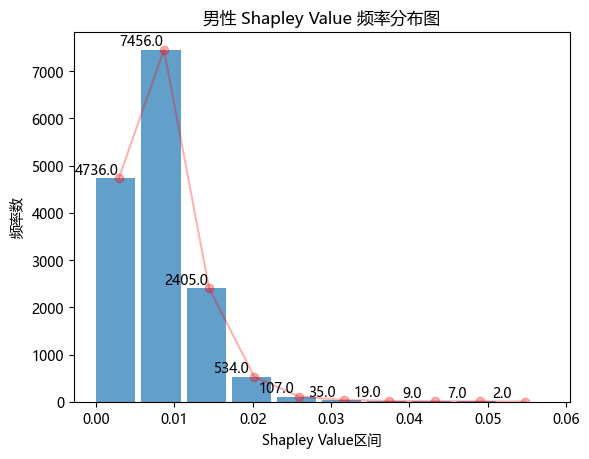

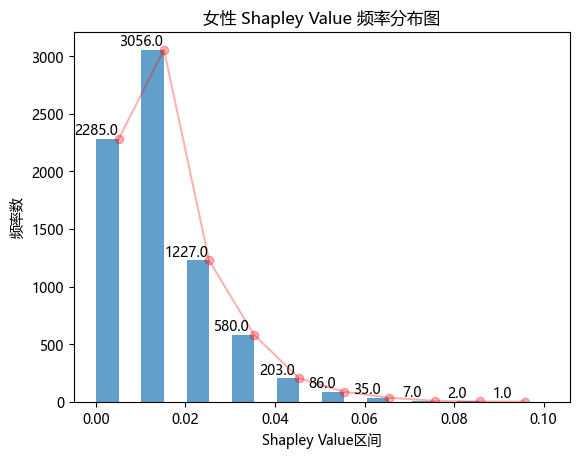

In [110]:
# 可以看到 大于 0.04 的数据比较少，说明不太合理，认为这些是不合理的数据
plt_hist_freq(shap_distance_male, 10, xlabel="Shapley Value区间", ylabel="频率数", title="男性 Shapley Value 频率分布图")
plt_hist_freq(shap_distance_female, 10, xlabel="Shapley Value区间", ylabel="频率数", title="女性 Shapley Value 频率分布图")


In [111]:
# 所以设定阈值为 t=0.04
t = 0.03
# 统计大于阈值的数量
np.sum(shap_distance_male > t), np.sum(shap_distance_female > t)

(51, 942)

## 获得公平和不公平的 idx

In [112]:
# 统计大于阈值的 index
target = np.where(shap_distance_male > t)
unfair_idx_male = np.where(shap_distance_male > t)
fair_idx_male = np.where(shap_distance_male <= t)
assert len(shap_distance_male) == len(unfair_idx_male[0]) + len(
    fair_idx_male[0]
), "和不相等"
# 女性
unfair_idx_female = np.where(shap_distance_female > t)
fair_idx_female = np.where(shap_distance_female <= t)
assert len(shap_distance_female) == len(unfair_idx_female[0]) + len(
    fair_idx_female[0]
), "和不相等"

In [113]:
def index_mapper(a, idx1, idx2):
    """索引映射
    已知 b = a[idx1] 且 c = b[idx2]
    要定位 c 在 a 的位置，则 a[idx1[idx2]]"""
    if isinstance(a, np.ndarray):
        return a[idx1[idx2]]
    elif isinstance(a, pd.DataFrame):
        return a.iloc[idx1[idx2]]
    elif isinstance(a, pd.Series):
        return a.iloc[idx1[idx2]]
    raise BaseException("a 的类型是 ", type(a))

In [114]:
from sklearn.neighbors import NearestNeighbors
def get_knn_idx(knn_k, X_train, X_target):
    knn = NearestNeighbors(n_neighbors=knn_k)
    knn.fit(X_train)
    distance, idx = knn.kneighbors(X_target)
    return idx

In [115]:
knn_k = 7

In [116]:
# 获得【男性】公平样本和不公平样本
fair_samples_male = index_mapper(X_train, idxs_iloc_in_X_train_male, fair_idx_male)
unfair_samples_male = index_mapper(X_train, idxs_iloc_in_X_train_male, target)
knn_idx_male = get_knn_idx(knn_k, fair_samples_male, unfair_samples_male)

In [117]:
# 获得【女性】公平样本和不公平样本
fair_samples_female = index_mapper(X_train, idxs_iloc_in_X_train_female, fair_idx_female)
unfair_samples_female = index_mapper(X_train, idxs_iloc_in_X_train_female, unfair_idx_female)
knn_idx_female = get_knn_idx(knn_k, fair_samples_female, unfair_samples_female)

In [118]:
from scipy import stats

def need_modify_idx(target, y_train, idx1, knn_idxs):
    count = 0
    total = len(target)
    unfair_list = []
    # 对于每个不公平样本进行遍历
    for i in range(total):
        # 不公平样本
        unfair_sample_idx = target[i]
        idx2 = idx1[unfair_sample_idx] # unfair_sample 在 X_train 上的 idx
        unfair_sample = index_mapper(y_train, idx1, unfair_sample_idx)

        # 近邻的公平样本
        fair_samples_idx = knn_idxs[i]
        knn_samples = index_mapper(y_train, idx1, fair_samples_idx)

        # 统计计算
        fair_mode = stats.mode(knn_samples).mode
        if fair_mode != unfair_sample:
            count += 1
            unfair_list.append(idx2)
    print(f"总数是 {total}，其中有 {count} 个不同", count, total)
    return np.array(unfair_list)
# 获得男性需要改变的 list
unfair_need_modify_male = need_modify_idx(unfair_idx_male[0], y_train, idxs_iloc_in_X_train_male, knn_idx_male)

# 获得女性需要改变的 list
unfair_need_modify_female = need_modify_idx(unfair_idx_female[0], y_train, idxs_iloc_in_X_train_female, knn_idx_female)

总数是 51，其中有 40 个不同 40 51

总数是 942，其中有 123 个不同 123 942

In [155]:
# 合并向量
percent_m = 0.9
m = int(min(unfair_need_modify_male.shape[0], unfair_need_modify_female.shape[0]) * percent_m)
print(m, type(m))
random_index_male = np.random.choice(unfair_need_modify_male.shape[0], size=m, replace=False)
random_index_female = np.random.choice(unfair_need_modify_female.shape[0], size=m, replace=False)
unfair_list_np = np.concatenate((unfair_need_modify_male[random_index_male], unfair_need_modify_female[random_index_female]))
unfair_list_np.shape

36 <class 'int'>

(72,)

In [156]:
y_train_fair = y_train.copy()
y_train_fair.iloc[unfair_list_np] = 1 - y_train.iloc[unfair_list_np]

In [157]:
xgboost_fair, res_fair = train_model_and_test(
    X_train,
    y_train_fair,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="公平组",
)
res_fair

{'准确率[1.]': 0.8615006653700481,
 '精确率[1.]': 0.7598140495867769,
 '召回率[1.]': 0.6235693090292497,
 'FPR[0.]': 0.06275303643724696,
 'FNR[0.]': 0.3764306909707503,
 'F1 Score[1.]': 0.6849825378346915,
 '人口平等 差异[0.]': 0.17363184989996583,
 '人口平等 比率[1.]': 0.32343091560326,
 '机会均等 差异[0.]': 0.09009643710744253,
 '机会均等 比率[1.]': 0.29889562841578016}

In [158]:
df = pd.DataFrame([res_origin, res_fair],index=["origin", "shap-fair"])
df

,准确率[1.],精确率[1.],召回率[1.],FPR[0.],FNR[0.],F1 Score[1.],人口平等 差异[0.],人口平等 比率[1.],机会均等 差异[0.],机会均等 比率[1.]
origin,0.861194,0.759979,0.621450,0.062483,0.378550,0.683769,0.172093,0.326185,0.084317,0.300440
shap-fair,0.861501,0.759814,0.623569,0.062753,0.376431,0.684983,0.173632,0.323431,0.090096,0.298896


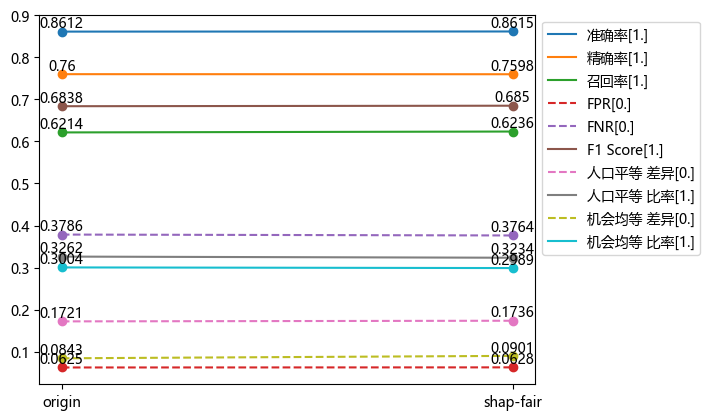

In [159]:
# 画在一张图上
cmap = plt.get_cmap("tab10")

# 初始化图例对象
scatter_legend = []

for i, col in enumerate(df.columns):
    values = df[col].values
    x = df.index
    linestyle = "-" if ("1" in col) else "--"
    line = plt.plot(
        x, values, linestyle=linestyle, label=col, color=cmap(i)
    )
    scatter = plt.scatter(x, values, color=cmap(i))

    # 在每个散点的位置添加数值标签
    y = values
    for i in range(len(x)):
        plt.text(x[i], y[i], str(round(y[i],4)), ha='center', va='bottom')
    
    # 将散点图的图例对象添加到列表中
    scatter_legend.append(scatter)

plt.legend(bbox_to_anchor=(1, 1), loc="upper left")

# plt.show()

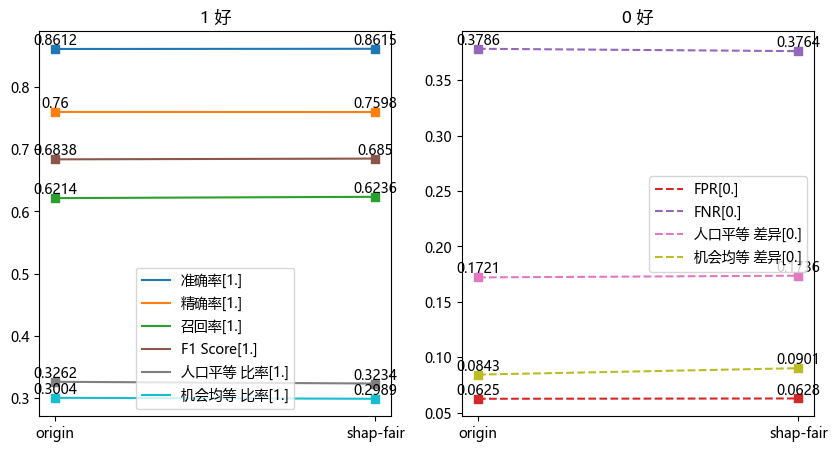

In [160]:
# 画在一张图上
cmap = plt.get_cmap("tab10")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


def plot_sub(ax, title, df: pd.DataFrame, filter, linestyle):
    # 初始化图例对象
    scatter_legend = []
    ax.set_title(title)
    for i, col in enumerate(df.columns):
        if filter(col):
            continue
        values = df[col].values
        x = df.index
        ax.plot(x, values, linestyle=linestyle, label=col, color=cmap(i))
        scatter = ax.scatter(x, values, marker="s", color=cmap(i))
        # 在每个散点的位置添加数值标签
        y = values
        for i in range(len(x)):
            ax.text(x[i], y[i], str(round(y[i], 4)), ha="center", va="bottom")
        # 将散点图的图例对象添加到列表中
        scatter_legend.append(scatter)
    ax.legend()
    # ax.legend(bbox_to_anchor=(1, 1), loc="upper left")


plot_sub(ax1, "1 好", df, lambda x: "1" not in x, "-")
plot_sub(ax2, "0 好", df, lambda x: "0" not in x, "--")

plt.show()